In [1]:
import sys
import os
import matplotlib.pyplot as plt
% matplotlib inline
import pickle
# Import class
parent_dir = os.path.dirname(os.getcwd())
class_dir = os.path.join(parent_dir, 'Scripts')
sys.path.insert(0, class_dir)
import NBAStats
import numpy as np
import datetime as dt
import pandas as pd

In [2]:
from statsmodels.stats.proportion import proportions_ztest

In [3]:
parent_dir = os.path.dirname(os.getcwd())
stats_file = os.path.join(parent_dir, 'Data', 'nba_stats.pickle')
print(stats_file)
nba_stats = pickle.load(open(stats_file, 'rb'))

C:\Users\johnn\Desktop\github\nba_stats\Data\nba_stats.pickle


In [4]:
def get_player_df(nba_stats, player, player_id=False):
    ''' Get the dataframe containing info on referenced player. If player_id=True, player id given instead of name'''
    if player_id:
        if player not in nba_stats.get_player_stats().keys():
            raise ValueError('player_id {} not found'.format(player))
        
        return nba_stats.get_player_stats()[player].sort_index(ascending=False)
    else:
        if player not in nba_stats.get_player_name_id_dict().keys():
            raise ValueError('player name {} not found'.format(player))
        
        return nba_stats.get_player_stats()[nba_stats.get_player_name_id_dict()[player]].sort_index(ascending=False)

In [5]:
def player_df_convert_numeric(player_df):
    ''' Returns a dataframe that converts relevant columns to numeric 
    Columns converted:
    MIN
    '''
    player_df['MIN'] = player_df['MIN'].apply(
        lambda str_min: int(str_min[:-3]) + int(str_min[-2:])/60.0 if str_min is not None else 0 )

    return player_df

# Motivation

Bet on the spread between the team's winning odds and the player points odds. If we can find a significant relationship between how much a player scores and the result of the game, we can capture deviations from the implied probabilities. Suppose in the case below, it seems like the probability that James Harden scores more than 25.5 points is significantly higher for wins that for losses.

Using this, we can work out our theo probability based off the game's implied probability. We can then either back the player and lay the team or vice versa (assuming there is a positive relationship). Although this probability can be reversed (working out team's odds based on player's odds), the spread for the team odds would be much tighter, and with more turnover, it is likely to be more accurate.

Suppose we back the player and lay the team. What we are essentially betting on is either the team is overpriced or the player is underpriced. More likely than not, the player is underpriced. The worst case scenario here is that the team wins and the player doesn't score the baseline.

## Use
From what I've seen, there doesn't seem to be a very active market in the player points market. So I might try to use this as a market making tool.

Can back player overs at 4.41 and player unders at 1.293314


,Over,Under
Win,0.026277,0.247723
Lose,0.148423,0.531849


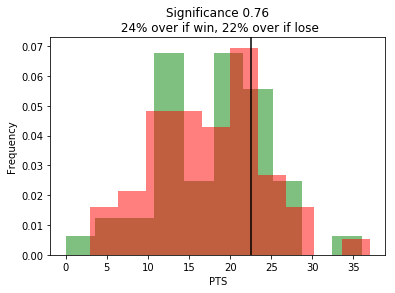

In [92]:
player_name = 'Julius Randle'
stat = 'PTS'
baseline = 22.5
team_opp_odds = (3.05, 1.47) # A tuple containing the odds for the player's team and their opponent
past_n_games = 100

player_df = get_player_df(nba_stats, player_name)
player_df = player_df_convert_numeric(player_df)
player_df_played = player_df[player_df.MIN > 0]
player_df_past_100 = player_df_played.head(past_n_games)

# Merge each game with outcome
df_games = nba_stats.get_games()
player_df_past_100_wl = player_df_past_100.merge(df_games[['GAME_ID', 'TEAM_ID', 'WL']],
                                                how='left')

# Remove any duplicates (don't know why there are duplicates)
player_df_past_100_wl = player_df_past_100_wl[~player_df_past_100_wl.duplicated()]

stat_win = player_df_past_100_wl[player_df_past_100_wl['WL'] == 'W'][stat]
stat_lose = player_df_past_100_wl[player_df_past_100_wl['WL'] == 'L'][stat]

stat_win.plot(kind='hist', density=True, alpha=0.5, color='green')
stat_lose.plot(kind='hist', density=True, alpha=0.5, color='red')

# plot baseline
plt.axvline(x=baseline, color='black')

# Calculate proportions
n_over_baseline_win = len(stat_win[stat_win>baseline])
n_over_baseline_lose = len(stat_lose[stat_lose>baseline])

n_win = len(stat_win)
n_lose = len(stat_lose)
n = n_win + n_lose

pr_over_baseline_win = n_over_baseline_win/n_win
pr_over_baseline_lose = n_over_baseline_lose/n_lose

# Conduct hypothesis test
counts = [n_over_baseline_win, n_over_baseline_lose]
nobs = [n_win, n_lose]

test_stat, pval = proportions_ztest(counts, nobs)

plt.title('Significance {:3.2f}\n {:2.0%} over if win, {:2.0%} over if lose'.format(pval, pr_over_baseline_win,
                                                                  pr_over_baseline_lose))
plt.xlabel('PTS')

team_win_IP = 1/float(team_opp_odds[0])
team_lose_IP = 1/float(team_opp_odds[1])

# If I want to back the player to score over, I have to back the opponent's team
theo_player_over_pr = (1-team_lose_IP) * pr_over_baseline_win + (team_lose_IP) * pr_over_baseline_lose

# If I want to back the player to score under, I have to back the player's team
theo_player_under_pr = 1 - ((team_win_IP) * pr_over_baseline_win + (1-team_win_IP) * pr_over_baseline_lose)

# Print conclusion
print('Can back player overs at {:.2f} and player unders at {:2f}'.format(1/theo_player_over_pr,
                                                                         1/theo_player_under_pr))

df_IP = pd.DataFrame({'Under':[team_win_IP * (1-pr_over_baseline_win), 
                                          team_lose_IP * (1-pr_over_baseline_lose)],
                      'Over':[team_win_IP * team_win_IP * pr_over_baseline_win,
                              team_lose_IP * pr_over_baseline_lose]},
                    index=['Win', 'Lose'])
df_IP


Based on past 100 games empirical
Can back over at 4.347826 and unders at 1.298701


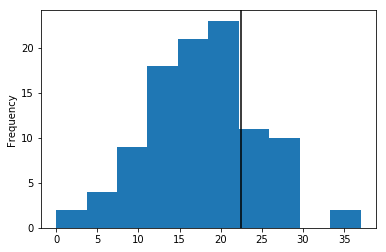

In [93]:
player_df_past_100['PTS'].plot(kind='hist')
plt.axvline(x=baseline, color='black')
pr_over_baseline = (n_over_baseline_lose + n_over_baseline_win)/float(n)

assert n_over_baseline_lose + n_over_baseline_win == (player_df_past_100['PTS'] > baseline).sum()
print('Based on past 100 games empirical\nCan back over at {:2f} and unders at {:2f}'.format(1/pr_over_baseline,
                                                                                            1/(1-pr_over_baseline)))

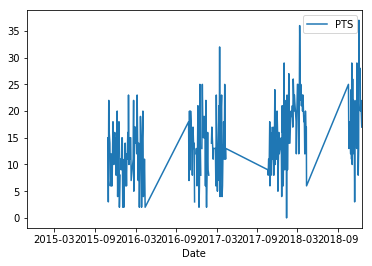

In [94]:
player_df.plot(y='PTS')

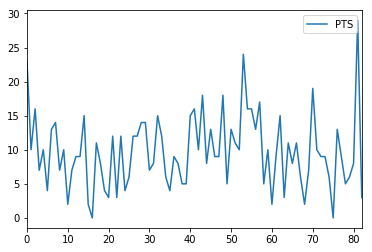

In [90]:
player_df_past_100_wl.plot(y='PTS')